# Demo

This notebook is provided to describe the usage of pydpac using a one-dimensional toy model known as [the Lorenz (1996) model](https://doi.org/10.1175/1520-0469(1998)055%3C0399:OSFSWO%3E2.0.CO;2) described by the following equation.
$$
\frac{dX_j}{dt} = (X_{j+1} - X_{j-2})X_{j-1} - X_j + F
$$

## Available DA algorithms

A data assimilation (DA) algorithm can be chosen from the followings.

文献のリンクをdoiで貼ってください。

- Kalman Filter ([Kalman 1960](https://doi.org/10.1115/1.3662552))
- 3DVar, 4DVar ([Talagrand and Courtier 1987](https://doi.org/10.1002/qj.49711347812))
- Ensemble Kalman Filter([Evensen 1994](https://doi.org/10.1029/94JC00572))
 * ETKF ([Bishop et al. 2001](https://doi.org/10.1175/1520-0493(2001)129%3C0420:ASWTET%3E2.0.CO;2))
 * PO ([Burgers et al. 1998](https://doi.org/10.1175/1520-0493(1998)126%3C1719:ASITEK%3E2.0.CO;2), [Houtekamer et al.2005](https://doi.org/10.1175/MWR-2864.1))
 * EnSRF ([Whitaker and Hamill 2002](https://doi.org/10.1175/1520-0493(2002)130%3C1913:EDAWPO%3E2.0.CO;2))
 * LETKF ([Hunt et al. 2007](https://doi.org/10.1016/j.physd.2006.11.008))
- Maximum Likelihoon Ensemble Filter ([Zupanski 2005](https://doi.org/10.1175/MWR2946.1), [Zupanski et al. 2008](https://doi.org/10.1002/qj.251))

## Requirements

- numpy for the model and DA
- pandas for error statistics
- matplotlib for plots

## Usage

Execute the cells below sequentially.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.lorenz import L96
from analysis.obs import Obs

In [2]:
# model parameter
#model = "l96"

global nx, F, dt

nx = 40     # number of points
F  = 8.0    # forcing
dt = 0.05 / 6  # time step (=1 hour)

# forecast model forward operator
step = L96(nx, dt, F)

In [3]:
# DA experiment parameter (default)
nmem =   20 # ensemble size
t0off =   8 # initial offset between adjacent members
t0c =    500 # t0 for control
t0m = [t0c + t0off//2 + t0off * i for i in range(-nmem//2, nmem//2)] # t0 for ensemble members
t0f = [t0c] + t0m 
nt =     6 # number of step per forecast (=6 hour)
na =   100 # number of analysis
namax = 1460 # max number of analysis (1 year)

sigma = {"linear": 1.0, "quadratic": 8.0e-1, "cubic": 7.0e-2, \
    "quadratic-nodiff": 8.0e-1, "cubic-nodiff": 7.0e-2, "test":1.0}
ftype = {"mlef":"ensemble","grad":"ensemble","etkf":"ensemble",\
    "po":"ensemble","srf":"ensemble","letkf":"ensemble",\
        "kf":"deterministic","var":"deterministic","var4d":"deterministic"}

In [4]:
# DA experiment parameters (custom)
# operator = observation type, perturbation = DA type
htype = {"operator": "linear", "perturbation": "mlef"}
linf = True # inflation switch (True=Apply, False=Not apply)
lloc = True # localization switch (True=Apply, False=Not apply)
ltlm = True  # tangent linear model switch (True=Use, False=Not use)
a_window = 1 # assimilation window length (for 4dVar)

In [5]:
# module setting
global op, pt, ft

op = htype["operator"]
pt = htype["perturbation"]
ft = ftype[pt]

# observation operator
obs = Obs(op, sigma[op])

# specify assimilation method
from analysis.mlef import Mlef
#analysis = Mlef(pt, obs, 1.1, model)
analysis = Mlef(pt, obs, 1.1)
#from analysis.enkf import EnKF
#analysis = EnKF(pt, obs, 1.1, 4.0, model)
#from analysis.kf import Kf
#analysis = Kf(pt, obs, 1.1, step)
#from analysis.var import Var
#analysis = Var(pt, obs, model)
#from analysis.var4d import Var4d
#analysis = Var4d(pt, obs, model, step, nt, a_window)

2020-11-26 15:48:28,910 anl INFO model : model
2020-11-26 15:48:28,911 anl INFO pt=mlef op=linear sig=1.0 infl_parm=1.1


In [6]:
# load functions
from l96_func import L96_func
params = {"step":step, "obs":obs, "analysis":analysis, \
    "nmem":nmem, "t0c":t0c, "t0f":t0f, "nt":nt, "na":na,\
    "namax":namax, "a_window":a_window, "op":op, "pt":pt, "ft":ft,\
    "linf":linf, "lloc":lloc, "ltlm":ltlm}
func = L96_func(params)

以下のコードのコメントを加えてください。

In [7]:
# get truth and make observation
xt, yobs = func.get_true_and_obs()
# initialize all variables
u, xa, xf, pf, sqrtpa = func.initialize(opt=0)
 
# analysis-forecast cycle timelot 
# (if analysis is 4-dimensional, analysis is taken every a_window steps.)
a_time = range(0, na, a_window)
e = np.zeros(na) # RMSE between Truth and Analysis
chi = np.zeros(na) # Chi2 test (values are nearly equal to 1 is good)
for i in a_time:
    # read observation
    y = yobs[i:i+a_window]
    # analysis
    if a_window > 1: # assimilate observations at different time (4-dimensional)
        u, pa, chi2 = analysis(u, pf, y, \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)
    else: # assimilate observations at a time
        u, pa, chi2 = analysis(u, pf, y[0], \
                    infl=linf, loc=lloc, tlm=ltlm,\
                    icycle=i)

    xa[i] = u # analysis
    sqrtpa[i] = pa # (mlef) analysis error covariance square root matrix
                   # (other) analysis error covariance matrix
    chi[i] = chi2
    if i < na-1:
        # forecast
        if a_window > 1: # 4-dimensional
            uf, p = func.forecast(u, pa)
            if (i+1+a_window <= na):
                xa[i+1:i+1+a_window] = uf
                xf[i+1:i+1+a_window] = uf
                sqrtpa[i+1:i+1+a_window, :, :] = p[:, :]
            else:
                xa[i+1:na] = uf[:na-i-1]
                xf[i+1:na] = uf[:na-i-1]
                sqrtpa[i+1:na, :, :] = p[:na-i-1, :, :]
            u = uf[-1]
            pf = p[-1]
        else:
            u, pf = func.forecast(u, pa, tlm=ltlm)
            xf[i+1] = u
    # calcurate RMSE and save
    if a_window > 1: # 4-dimensional
        if ft == "deterministic":
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :] - xt[k, :])**2))
        else:
            for k in range(i, min(i+a_window,na)):
                e[k] = np.sqrt(np.mean((xa[k, :, 0] - xt[k, :])**2))
    else:
        if ft == "deterministic":
            e[i] = np.sqrt(np.mean((xa[i, :] - xt[i, :])**2))
        else:
            e[i] = np.sqrt(np.mean((xa[i, :, 0] - xt[i, :])**2))
    

2020-11-26 16:08:07,045 anl INFO save_dh=False
2020-11-26 16:08:07,052 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 16:08:07,053 anl INFO save_hist=False
2020-11-26 16:08:07,161 anl INFO success=False message=Desired error not necessarily achieved due to precision loss.
2020-11-26 16:08:07,162 anl INFO J=1.231e+02 dJ=1.185e-04 nit=94
2020-11-26 16:08:07,169 anl INFO singular value =[105.99113585  38.13524932  35.8578695   31.12099376  29.4692073
  25.79978467  25.24021611  25.0192644   23.74786284  20.64818166
  18.78997099  17.29075623  15.33695105  14.804286    13.3881681
  12.40113076  10.51493372  10.05229209   8.93427813   7.94567228]
2020-11-26 16:08:07,170 anl INFO ==inflation==
2020-11-26 16:08:07,175 anl INFO save_dh=False
2020

2020-11-26 16:08:07,509 anl INFO singular value =[0.8920806  0.85823361 0.84882475 0.79548082 0.76027976 0.65664419
 0.61294489 0.58321803 0.55169896 0.54639011 0.49718945 0.49023501
 0.46475509 0.43365256 0.42224089 0.37252642 0.36696017 0.34790143
 0.29191574 0.27369116]
2020-11-26 16:08:07,510 anl INFO ==inflation==
2020-11-26 16:08:07,514 anl INFO save_dh=False
2020-11-26 16:08:07,522 anl INFO singular value =[0.87411217 0.83839134 0.81076035 0.75154323 0.73950031 0.64845848
 0.63670513 0.59623625 0.57002259 0.52264502 0.49723947 0.45807767
 0.45212192 0.39600886 0.38965504 0.35755454 0.35329021 0.32725133
 0.2805543  0.26632572]
2020-11-26 16:08:07,523 anl INFO save_hist=False
2020-11-26 16:08:07,528 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:07,528 anl INFO J=7.973e+01 dJ=6.725e-07 nit=7
2020-11-26 16:08:07,536 anl INFO singular value =[0.87411217 0.83839134 0.81076035 0.75154323 0.73950031 0.64845848
 0.63670513 0.59623625 0.57002259 0.5

2020-11-26 16:08:07,776 anl INFO save_hist=False
2020-11-26 16:08:07,781 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:07,782 anl INFO J=5.258e+01 dJ=1.416e-06 nit=8
2020-11-26 16:08:07,790 anl INFO singular value =[1.12512547 0.91239252 0.86866416 0.82980575 0.7604917  0.66608675
 0.62862127 0.59611491 0.58594836 0.45669368 0.43333181 0.41866587
 0.33678775 0.33049945 0.30570739 0.28458245 0.27258921 0.24548903
 0.18489883 0.15503984]
2020-11-26 16:08:07,791 anl INFO ==inflation==
2020-11-26 16:08:07,797 anl INFO save_dh=False
2020-11-26 16:08:07,804 anl INFO singular value =[1.1228521  0.92686667 0.86146591 0.77883972 0.74787175 0.65400732
 0.64782064 0.56729972 0.52215778 0.4519862  0.42714319 0.41255227
 0.3634366  0.34502556 0.29012879 0.28079643 0.25905755 0.24727436
 0.18301508 0.14840008]
2020-11-26 16:08:07,805 anl INFO save_hist=False
2020-11-26 16:08:07,811 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 1

2020-11-26 16:08:08,060 anl INFO save_hist=False
2020-11-26 16:08:08,065 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:08,066 anl INFO J=2.415e+01 dJ=2.066e-06 nit=7
2020-11-26 16:08:08,073 anl INFO singular value =[0.95714753 0.85368127 0.77089682 0.71293144 0.69008004 0.65070619
 0.59168167 0.57504748 0.54705426 0.50392638 0.45780614 0.43596347
 0.40205019 0.38333331 0.31781411 0.2932793  0.23698165 0.20493123
 0.18031516 0.12513893]
2020-11-26 16:08:08,075 anl INFO ==inflation==
2020-11-26 16:08:08,079 anl INFO save_dh=False
2020-11-26 16:08:08,086 anl INFO singular value =[1.00268412 0.81870208 0.79041193 0.72973946 0.70432188 0.66478683
 0.62460397 0.61433322 0.57386691 0.49128745 0.45639723 0.42472674
 0.40556637 0.37660737 0.32308223 0.29308397 0.23357593 0.19655681
 0.17124283 0.11903478]
2020-11-26 16:08:08,087 anl INFO save_hist=False
2020-11-26 16:08:08,092 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 1

2020-11-26 16:08:08,333 anl INFO save_hist=False
2020-11-26 16:08:08,337 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:08,338 anl INFO J=2.016e+01 dJ=2.570e-06 nit=7
2020-11-26 16:08:08,345 anl INFO singular value =[1.01488784 0.97108201 0.79054649 0.77270454 0.72575143 0.66461109
 0.63399652 0.55137295 0.54450132 0.52083385 0.50994319 0.45558793
 0.35397196 0.30938539 0.27607733 0.24789467 0.21487118 0.19043166
 0.16489357 0.13358718]
2020-11-26 16:08:08,346 anl INFO ==inflation==
2020-11-26 16:08:08,351 anl INFO save_dh=False
2020-11-26 16:08:08,358 anl INFO singular value =[1.02030009 0.99219502 0.80700984 0.7919331  0.76145842 0.68192692
 0.64345577 0.55965175 0.54363936 0.51806312 0.51208579 0.4828084
 0.3375798  0.31052149 0.26998606 0.23570734 0.20514417 0.18058056
 0.15899087 0.12510846]
2020-11-26 16:08:08,359 anl INFO save_hist=False
2020-11-26 16:08:08,363 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16

2020-11-26 16:08:08,610 anl INFO save_hist=False
2020-11-26 16:08:08,616 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:08,616 anl INFO J=1.672e+01 dJ=8.584e-08 nit=8
2020-11-26 16:08:08,624 anl INFO singular value =[0.93410313 0.9177753  0.85060513 0.75652365 0.69520141 0.64592568
 0.614829   0.57159156 0.52297098 0.46964853 0.46364868 0.42353987
 0.38901098 0.3406085  0.33068361 0.2949075  0.28300625 0.23416606
 0.16909828 0.12988423]
2020-11-26 16:08:08,625 anl INFO ==inflation==
2020-11-26 16:08:08,630 anl INFO save_dh=False
2020-11-26 16:08:08,637 anl INFO singular value =[1.00065316 0.87518722 0.83533474 0.70566242 0.68116036 0.65029695
 0.61130024 0.53193702 0.49767083 0.47435187 0.46327608 0.40937566
 0.38524367 0.36441152 0.32127327 0.29582087 0.27327441 0.22980225
 0.18364209 0.13563896]
2020-11-26 16:08:08,638 anl INFO save_hist=False
2020-11-26 16:08:08,643 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 1

2020-11-26 16:08:08,880 anl INFO singular value =[0.96169921 0.85840188 0.83165936 0.70254044 0.66962296 0.60741877
 0.58048464 0.5497269  0.50716491 0.47008231 0.42361688 0.4078202
 0.4045953  0.36914454 0.31395039 0.29426781 0.24937367 0.18664015
 0.15537228 0.13561967]
2020-11-26 16:08:08,882 anl INFO save_hist=False
2020-11-26 16:08:08,886 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:08,887 anl INFO J=1.697e+01 dJ=1.477e-06 nit=7
2020-11-26 16:08:08,894 anl INFO singular value =[0.96169921 0.85840188 0.83165936 0.70254044 0.66962296 0.60741877
 0.58048464 0.5497269  0.50716491 0.47008231 0.42361688 0.4078202
 0.4045953  0.36914454 0.31395039 0.29426781 0.24937367 0.18664015
 0.15537228 0.13561967]
2020-11-26 16:08:08,895 anl INFO ==inflation==
2020-11-26 16:08:08,901 anl INFO save_dh=False
2020-11-26 16:08:08,908 anl INFO singular value =[0.98267663 0.89224878 0.82184283 0.72606172 0.68019671 0.63639198
 0.5898603  0.51038129 0.49465395 0.467

2020-11-26 16:08:09,133 anl INFO ==inflation==
2020-11-26 16:08:09,139 anl INFO save_dh=False
2020-11-26 16:08:09,147 anl INFO singular value =[0.91984254 0.87368603 0.85547163 0.65847007 0.63637395 0.61276331
 0.60178533 0.55108982 0.53638115 0.52782519 0.45929146 0.44713954
 0.39375819 0.35663673 0.34402412 0.31452142 0.22456455 0.19246616
 0.17602651 0.1076452 ]
2020-11-26 16:08:09,148 anl INFO save_hist=False
2020-11-26 16:08:09,152 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:09,153 anl INFO J=1.259e+01 dJ=5.971e-07 nit=7
2020-11-26 16:08:09,160 anl INFO singular value =[0.91984254 0.87368603 0.85547163 0.65847007 0.63637395 0.61276331
 0.60178533 0.55108982 0.53638115 0.52782519 0.45929146 0.44713954
 0.39375819 0.35663673 0.34402412 0.31452142 0.22456455 0.19246616
 0.17602651 0.1076452 ]
2020-11-26 16:08:09,161 anl INFO ==inflation==
2020-11-26 16:08:09,166 anl INFO save_dh=False
2020-11-26 16:08:09,173 anl INFO singular value =[0.9418825

2020-11-26 16:08:09,402 anl INFO ==inflation==
2020-11-26 16:08:09,407 anl INFO save_dh=False
2020-11-26 16:08:09,414 anl INFO singular value =[0.81327194 0.79509533 0.74720895 0.69395575 0.67653204 0.65138542
 0.52544933 0.5038263  0.48757623 0.4760112  0.4304298  0.38536165
 0.38024707 0.3499619  0.31002635 0.29586098 0.25716044 0.21537048
 0.17768664 0.15666853]
2020-11-26 16:08:09,415 anl INFO save_hist=False
2020-11-26 16:08:09,419 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:09,420 anl INFO J=1.635e+01 dJ=9.491e-07 nit=6
2020-11-26 16:08:09,428 anl INFO singular value =[0.81327194 0.79509533 0.74720895 0.69395575 0.67653204 0.65138542
 0.52544933 0.5038263  0.48757623 0.4760112  0.4304298  0.38536165
 0.38024707 0.3499619  0.31002635 0.29586098 0.25716044 0.21537048
 0.17768664 0.15666853]
2020-11-26 16:08:09,429 anl INFO ==inflation==
2020-11-26 16:08:09,434 anl INFO save_dh=False
2020-11-26 16:08:09,441 anl INFO singular value =[0.8448308

2020-11-26 16:08:09,668 anl INFO ==inflation==
2020-11-26 16:08:09,673 anl INFO save_dh=False
2020-11-26 16:08:09,681 anl INFO singular value =[0.80188217 0.75969831 0.74740866 0.70377837 0.69359173 0.65497026
 0.56674409 0.52176803 0.50463032 0.48433891 0.44343339 0.41875164
 0.3939833  0.35595795 0.31700901 0.27993973 0.26320889 0.20757046
 0.18498714 0.1443593 ]
2020-11-26 16:08:09,682 anl INFO save_hist=False
2020-11-26 16:08:09,686 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:09,687 anl INFO J=1.728e+01 dJ=6.411e-07 nit=6
2020-11-26 16:08:09,694 anl INFO singular value =[0.80188217 0.75969831 0.74740866 0.70377837 0.69359173 0.65497026
 0.56674409 0.52176803 0.50463032 0.48433891 0.44343339 0.41875164
 0.3939833  0.35595795 0.31700901 0.27993973 0.26320889 0.20757046
 0.18498714 0.1443593 ]
2020-11-26 16:08:09,695 anl INFO ==inflation==
2020-11-26 16:08:09,700 anl INFO save_dh=False
2020-11-26 16:08:09,708 anl INFO singular value =[0.7891358

2020-11-26 16:08:09,944 anl INFO ==inflation==
2020-11-26 16:08:09,948 anl INFO save_dh=False
2020-11-26 16:08:09,956 anl INFO singular value =[0.83339333 0.82836178 0.79174245 0.70249588 0.68215279 0.65081419
 0.60053139 0.53506088 0.49599138 0.46040505 0.45730648 0.42925161
 0.4022689  0.39034153 0.32293163 0.26139779 0.2385895  0.19033303
 0.16185242 0.15982849]
2020-11-26 16:08:09,957 anl INFO save_hist=False
2020-11-26 16:08:09,961 anl INFO success=True message=Optimization terminated successfully.
2020-11-26 16:08:09,962 anl INFO J=1.598e+01 dJ=1.741e-06 nit=6
2020-11-26 16:08:09,973 anl INFO singular value =[0.83339333 0.82836178 0.79174245 0.70249588 0.68215279 0.65081419
 0.60053139 0.53506088 0.49599138 0.46040505 0.45730648 0.42925161
 0.4022689  0.39034153 0.32293163 0.26139779 0.2385895  0.19033303
 0.16185242 0.15982849]
2020-11-26 16:08:09,974 anl INFO ==inflation==


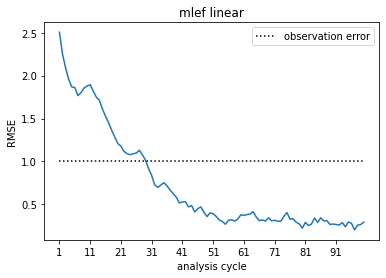

In [8]:
obs_s = sigma[op]
x = np.arange(na) + 1
y = np.ones(x.size) * obs_s
fig, ax = plt.subplots()
ax.plot(x, e)
ax.plot(x, y, linestyle="dotted", color="black", label="observation error")
ax.set(xlabel="analysis cycle", ylabel="RMSE", title=pt+" "+op)
ax.set_xticks(x[::10])
ax.set_xticks(x[::20],minor=True)
ax.legend()
plt.show()